<a href="https://colab.research.google.com/github/chaos44/generative_deep_learning/blob/main/chap7/7_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone -b tensorflow_2 https://github.com/davidADSP/GDL_code.git

Cloning into 'GDL_code'...
remote: Enumerating objects: 391, done.
remote: Total 391 (delta 0), reused 0 (delta 0), pack-reused 391
Receiving objects: 100% (391/391), 22.13 MiB | 33.62 MiB/s, done.
Resolving deltas: 100% (237/237), done.


In [2]:
cd GDL_code/

/content/GDL_code


In [3]:
pip install --upgrade music21

     |████████████████████████████████| 19.2MB 47.1MB/s 
  Created wheel for music21: filename=music21-6.3.0-cp36-none-any.whl size=21888021 sha256=1bd67fe46291d0c4d62134db666b0b63f3ef651e5e867779c52f32ed538c243c
  Stored in directory: /root/.cache/pip/wheels/02/e8/2c/eed32afec2b6c6f945a17280c4e4df1cf2e8cd15ebe1025680
Successfully built music21
  Found existing installation: music21 5.5.0
    Uninstalling music21-5.5.0:
      Successfully uninstalled music21-5.5.0


In [4]:
from music21 import converter, chord, note

## **Compose: Training a model to generate music**



In [5]:
import os
import pickle
import numpy
from music21 import note, chord

from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import plot_model

from models.RNNAttention import get_distinct, create_lookups, prepare_sequences, get_music_list, create_network

### **Set parameters**

In [6]:
# run params
section = 'compose'
run_id = '0006'
music_name = 'cello'

run_folder = 'run/{}/'.format(section)
run_folder += '_'.join([run_id, music_name])


store_folder = os.path.join(run_folder, 'store')
data_folder = os.path.join('data', music_name)

if not os.path.exists(run_folder):
    os.mkdir(run_folder)
    os.mkdir(os.path.join(run_folder, 'store'))
    os.mkdir(os.path.join(run_folder, 'output'))
    os.mkdir(os.path.join(run_folder, 'weights'))
    os.mkdir(os.path.join(run_folder, 'viz'))
    


mode = 'build' # 'load' # 

# data params
intervals = range(1)
seq_len = 32

# model params
embed_size = 100
rnn_units = 256
use_attention = True

### **Extract the notes**

In [7]:
if mode == 'build':
    
    music_list, parser = get_music_list(data_folder)
    print(len(music_list), 'files in total')

    notes = []
    durations = []

    for i, file in enumerate(music_list):
        print(i+1, "Parsing %s" % file)
        original_score = parser.parse(file).chordify()
        

        for interval in intervals:

            score = original_score.transpose(interval)

            notes.extend(['START'] * seq_len)
            durations.extend([0]* seq_len)

            for element in score.flat:
                
                if isinstance(element, note.Note):
                    if element.isRest:
                        notes.append(str(element.name))
                        durations.append(element.duration.quarterLength)
                    else:
                        notes.append(str(element.nameWithOctave))
                        durations.append(element.duration.quarterLength)

                if isinstance(element, chord.Chord):
                    notes.append('.'.join(n.nameWithOctave for n in element.pitches))
                    durations.append(element.duration.quarterLength)

    with open(os.path.join(store_folder, 'notes'), 'wb') as f:
        pickle.dump(notes, f) #['G2', 'D3', 'B3', 'A3', 'B3', 'D3', 'B3', 'D3', 'G2',...]
    with open(os.path.join(store_folder, 'durations'), 'wb') as f:
        pickle.dump(durations, f) 
else:
    with open(os.path.join(store_folder, 'notes'), 'rb') as f:
        notes = pickle.load(f) #['G2', 'D3', 'B3', 'A3', 'B3', 'D3', 'B3', 'D3', 'G2',...]
    with open(os.path.join(store_folder, 'durations'), 'rb') as f:
        durations = pickle.load(f)

1 files in total
1 Parsing data/cello/cs1-3cou.mid


### **Create the lookup tables**

In [8]:
# get the distinct sets of notes and durations
note_names, n_notes = get_distinct(notes)
duration_names, n_durations = get_distinct(durations)
distincts = [note_names, n_notes, duration_names, n_durations]

with open(os.path.join(store_folder, 'distincts'), 'wb') as f:
    pickle.dump(distincts, f)

# make the lookup dictionaries for notes and dictionaries and save
note_to_int, int_to_note = create_lookups(note_names)
duration_to_int, int_to_duration = create_lookups(duration_names)
lookups = [note_to_int, int_to_note, duration_to_int, int_to_duration]

with open(os.path.join(store_folder, 'lookups'), 'wb') as f:
    pickle.dump(lookups, f)

In [9]:
print('\nnote_to_int')
note_to_int


note_to_int


{'A2': 0,
 'A3': 1,
 'B2': 2,
 'B3': 3,
 'C#3': 4,
 'C#4': 5,
 'C2': 6,
 'C3': 7,
 'C4': 8,
 'D2': 9,
 'D3': 10,
 'D4': 11,
 'E-3': 12,
 'E-4': 13,
 'E2': 14,
 'E3': 15,
 'E4': 16,
 'F#3': 17,
 'F3': 18,
 'G2': 19,
 'G2.G3': 20,
 'G3': 21,
 'START': 22}

In [10]:
print('\nduration_to_int')
duration_to_int


duration_to_int


{0: 0, 0.25: 1, 0.5: 2, 0.75: 3, 1.25: 4, 1.5: 5, 2.0: 6}

### **Prepare the sequences used by the Neural Network**

In [11]:
network_input, network_output = prepare_sequences(notes, durations, lookups, distincts, seq_len)

In [12]:
print('pitch input')
print(network_input[0][0])
print('duration input')
print(network_input[1][0])
print('pitch output')
print(network_output[0][0])
print('duration output')
print(network_output[1][0])

pitch input
[22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22
 22 22 22 22 22 22 22 22]
duration input
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
pitch output
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
duration output
[0. 0. 1. 0. 0. 0. 0.]


### **Create the structure of the neural network**

In [13]:
model, att_model = create_network(n_notes, n_durations, embed_size, rnn_units, use_attention)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 100)    2300        input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 100)    700         input_2[0][0]                    
______________________________________________________________________________________________

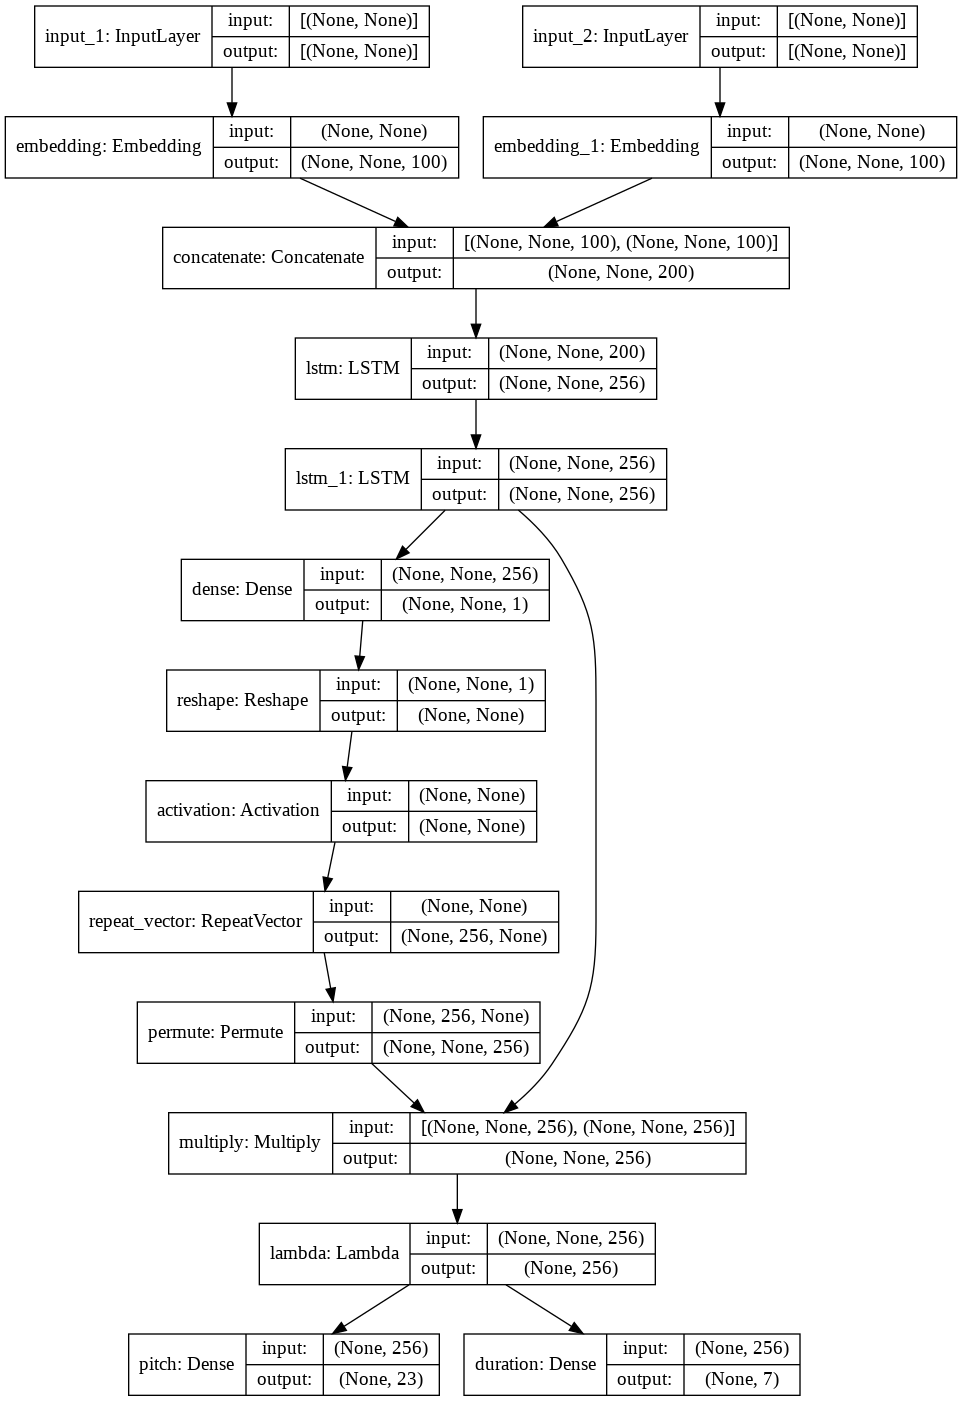

In [14]:
plot_model(model, to_file=os.path.join(run_folder ,'viz/model.png'), show_shapes = True, show_layer_names = True)

### **Train the neural network**

In [15]:
weights_folder = os.path.join(run_folder, 'weights')
# model.load_weights(os.path.join(weights_folder, "weights.h5"))

In [16]:
weights_folder = os.path.join(run_folder, 'weights')

checkpoint1 = ModelCheckpoint(
    os.path.join(weights_folder, "weights-improvement-{epoch:02d}-{loss:.4f}-bigger.h5"),
    monitor='loss',
    verbose=0,
    save_best_only=True,
    mode='min'
)

checkpoint2 = ModelCheckpoint(
    os.path.join(weights_folder, "weights.h5"),
    monitor='loss',
    verbose=0,
    save_best_only=True,
    mode='min'
)

early_stopping = EarlyStopping(
    monitor='loss'
    , restore_best_weights=True
    , patience = 10
)


callbacks_list = [
    checkpoint1
    , checkpoint2
    , early_stopping
 ]

model.save_weights(os.path.join(weights_folder, "weights.h5"))
# model.fit(network_input, network_output
#           , epochs=2000000, batch_size=32
#           , validation_split = 0.2
#           , callbacks=callbacks_list
#           , shuffle=True
#          )

model.fit(network_input, network_output
          , epochs=20, batch_size=32
          , validation_split = 0.2
          , callbacks=callbacks_list
          , shuffle=True
         )

Epoch 1/20
21/21 [==============================] - 11s 69ms/step - loss: 3.8331 - pitch_loss: 2.8380 - duration_loss: 0.9951 - val_loss: 3.5122 - val_pitch_loss: 2.7503 - val_duration_loss: 0.7619
Epoch 2/20
21/21 [==============================] - 0s 17ms/step - loss: 3.1426 - pitch_loss: 2.5694 - duration_loss: 0.5732 - val_loss: 3.5784 - val_pitch_loss: 2.7350 - val_duration_loss: 0.8434
Epoch 3/20
21/21 [==============================] - 0s 16ms/step - loss: 3.2155 - pitch_loss: 2.6027 - duration_loss: 0.6128 - val_loss: 3.1652 - val_pitch_loss: 2.7155 - val_duration_loss: 0.4497
Epoch 4/20
21/21 [==============================] - 0s 15ms/step - loss: 3.1324 - pitch_loss: 2.5525 - duration_loss: 0.5799 - val_loss: 3.7476 - val_pitch_loss: 2.8648 - val_duration_loss: 0.8828
Epoch 5/20
21/21 [==============================] - 0s 15ms/step - loss: 3.1731 - pitch_loss: 2.5824 - duration_loss: 0.5907 - val_loss: 3.2535 - val_pitch_loss: 2.7969 - val_duration_loss: 0.4565
Epoch 6/20
21/

### **/GDL_code/run/compose/0006_cello/weights/weights.h5 をDLして、7_3で使う**